In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A # for image augmentation
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [3]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [4]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [5]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [6]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [7]:
valid_df.head(10)

,image_id,width,height,source,x,y,w,h
122787,bbce58f71,1024,1024,arvalis_3,430.0,0.0,142.0,75.0
122788,bbce58f71,1024,1024,arvalis_3,255.0,377.0,100.0,69.0
122789,bbce58f71,1024,1024,arvalis_3,788.0,634.0,146.0,77.0
122790,bbce58f71,1024,1024,arvalis_3,344.0,836.0,102.0,110.0
122791,bbce58f71,1024,1024,arvalis_3,217.0,694.0,107.0,85.0


In [8]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [9]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [10]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [11]:
num_classes = 2  # foreground(wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [16]:
boxes = targets[8]['boxes'].cpu().numpy().astype(np.int32)
sample = images[8].permute(1,2,0).cpu().numpy()

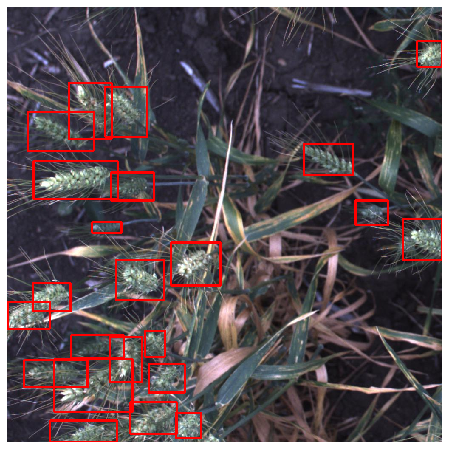

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [19]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.8768835067749023
Iteration #100 loss: 0.7166668772697449
Iteration #150 loss: 0.643791913986206
Epoch #0 loss: 0.8521080800715615
Iteration #200 loss: 0.706061601638794
Iteration #250 loss: 0.6902005672454834
Iteration #300 loss: 0.5935033559799194
Epoch #1 loss: 0.7134388362660128


# Testing

In [20]:
images, targets, image_ids = next(iter(valid_data_loader))

In [21]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [22]:
boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy()

In [23]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [36]:
outputs[0]['boxes']

tensor([[9.2911e+02, 9.1552e+02, 1.0240e+03, 1.0193e+03],
        [3.2396e+02, 9.2192e+02, 4.0620e+02, 1.0235e+03],
        [5.8049e+02, 5.6790e+01, 7.0242e+02, 1.2893e+02],
        [3.4201e+02, 8.3397e+02, 4.4839e+02, 9.4964e+02],
        [9.4200e+02, 8.0581e+02, 1.0240e+03, 9.0055e+02],
        [4.7256e+02, 3.1996e+02, 6.2613e+02, 3.9025e+02],
        [4.2568e+02, 3.0620e+00, 5.3458e+02, 8.4501e+01],
        [6.2869e+01, 1.3184e+00, 1.4972e+02, 7.0886e+01],
        [6.6899e+02, 9.3290e+01, 8.1797e+02, 1.8739e+02],
        [9.4949e+02, 7.0442e+02, 1.0240e+03, 7.7797e+02],
        [3.1385e+02, 5.8713e+02, 4.4555e+02, 6.8362e+02],
        [1.9293e+02, 4.7095e+02, 2.8049e+02, 5.4352e+02],
        [8.8973e+02, 1.7581e+02, 9.9558e+02, 2.3972e+02],
        [1.5660e+02, 3.0604e+02, 2.5251e+02, 3.9924e+02],
        [5.1478e+02, 4.6477e+02, 6.5499e+02, 5.3956e+02],
        [9.2361e+02, 4.7377e+02, 1.0240e+03, 5.5169e+02],
        [7.8617e+02, 4.0255e+02, 9.2365e+02, 4.8375e+02],
        [2.124

In [37]:
box_predict=outputs[0]['boxes'].data.cpu().numpy()
score= outputs[0]['scores'].data.cpu().numpy()

In [39]:
score

array([0.98704183, 0.9831042 , 0.981069  , 0.9792284 , 0.9790982 ,
       0.97807306, 0.9761554 , 0.9759076 , 0.97259337, 0.9721782 ,
       0.97086626, 0.9708453 , 0.97049284, 0.97024196, 0.96973675,
       0.9681153 , 0.96781284, 0.96374553, 0.962198  , 0.96048677,
       0.9597653 , 0.95648885, 0.9544694 , 0.95330733, 0.95326704,
       0.952251  , 0.9415409 , 0.93830574, 0.9379417 , 0.93643886,
       0.93171847, 0.9308891 , 0.920712  , 0.9183021 , 0.8951505 ,
       0.88220894, 0.8699917 , 0.82912314, 0.82645553, 0.7416118 ,
       0.672659  , 0.6282728 , 0.6271363 , 0.61142457, 0.5418579 ,
       0.34360734, 0.323773  , 0.30552533, 0.29484022, 0.28724372,
       0.24518779, 0.21259132, 0.16071445, 0.15903994, 0.15791912,
       0.10811168, 0.10543407, 0.10403673, 0.1028463 , 0.1022389 ,
       0.09279648, 0.09026022, 0.08691342, 0.08690313, 0.08302345,
       0.07896762, 0.076096  , 0.07576969, 0.07315958, 0.06214963,
       0.05824836, 0.05807327, 0.05519157], dtype=float32)

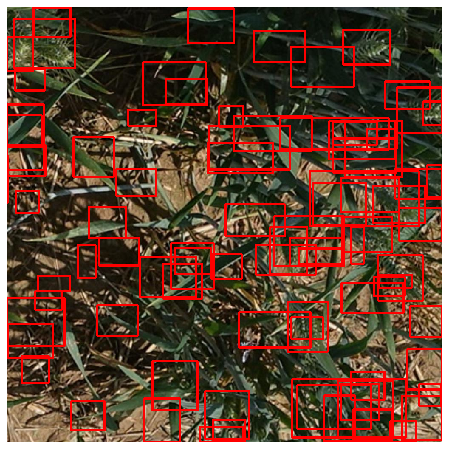

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in box_predict:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [25]:
torch.save(model.state_dict(), 'fasterRCNN.pth')

# Max POOL Supression needs to be checked to remove the extra boxes